# DR CRC Model: US Natural History Calibration
Sophie Wagner, sw3767@cumc.columbia.edu

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps #https://csaps.readthedocs.io/en/latest/
import common_functions as func
from scipy.interpolate import interp1d


In [2]:
# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Global Parameters
starting_age = 20
max_age = 100
N = 100000  # Size of sample populations

# State Structure
health_states = {'healthy': 0,
                 'LR_polyp': 1,
                 'HR_polyp': 2,
                 'u_CRC_loc': 3,
                 'u_CRC_reg': 4,
                 'u_CRC_dis': 5,
                 'd_CRC_loc': 6,
                 'd_CRC_reg': 7,
                 'd_CRC_dis': 8,
                 'cancer_death': 9,
                 'healthy_ACM': 10,
                 'cancer_ACM': 11,
                 'polyp_ACM': 12,  # death while in polyp state
                 'uCRC_ACM': 13}  # death while in undiagnosed state
acm_states = [10,12,12,13,13,13,11,11,11]

# Age Groupings (len=16)
#ages = {"20-25":0, "25-29":1, "30-35":2, "35-39":3, "40-45":4, "45-49":5, "50-54":6, "55-59":7, "60-64":8, 
#        "65-69":9, "70-74":10, "75-79":11, "80-84":12, "85-89":13, "90-95":14, "95+":15}
ages = np.arange(0,80,1)

starting_pop = np.zeros((len(health_states),1)) # (14,1)
starting_pop[0,0]=N # Everyone starts in healthy state

### Inputs
# All cause mortality
acm_1y=pd.read_excel("data/acm_us.xlsx", sheet_name='ACM_1y') # Age, Rate
acm_1y['Age Group'] = (acm_1y['Age'] // 5) * 5
acm_5y = acm_1y.groupby('Age Group')['Rate'].mean().reset_index() 
acm_5y = acm_5y[acm_5y['Age Group']>=20].reset_index() # age_layers 20-100 (16 items)
acm_5y = acm_5y[acm_5y['Age Group']<100].reset_index() # age_layers 20-100 (16 items)
#acm_rate = func.probtoprob(acm_5y['Rate']).to_numpy()
acm_1y = acm_1y[acm_1y['Age']>=20].reset_index()
acm_1y = acm_1y[acm_1y['Age']<100].reset_index(drop=True)
acm_rate = func.probtoprob(acm_1y['Rate']).to_numpy()
# Cancer specific death 
seer_surv = pd.read_excel("data/survival_km.xlsx", sheet_name="Survival").reset_index(drop=True) # In 5y age layers
seer_surv = seer_surv[seer_surv['Age']<100]
#csd_rate = seer_surv[['Local', 'Regional', 'Distant']].apply(lambda col: func.probtoprob(col)).to_numpy() # Convert to monthly probs
age_points = np.arange(20, 100, 5)  # Original age points (every 5 years)
new_age_points = np.arange(20, 100)  # New age points (every year)

csd_interp = {}
for col in ['Local', 'Regional', 'Distant']:
    f = interp1d(age_points, seer_surv[col], kind='linear', fill_value="extrapolate") # type: ignore
    csd_interp[col] = f(new_age_points)

csd_rate = pd.DataFrame(csd_interp).apply(lambda col: func.probtoprob(col)).to_numpy()
### Calibration Targets
# Target 1: SEER Incidence
seer_inc = pd.read_excel("data/incidence_crude.xlsx", sheet_name="1975-1990 Adj")
seer_inc = seer_inc[seer_inc['Age']>=20].reset_index() # single ages, 20-84 (65 ages)
seer_inc = seer_inc[seer_inc['Age']<=84].reset_index() # starting age 20, 65 ages

# Target 2: Polyp prevalence
polyp_prev = pd.read_excel("data/polyp_targets.xlsx", sheet_name="Sheet1")
polyp_targets=polyp_prev['Value'].to_numpy() # uCRC, polyp, uCRC + polyp 

In [4]:
print(acm_rate.shape, csd_rate.shape, ages.shape)

(80,) (80, 3) (80,)


In [48]:
def calculate_transition_probs_all_ages(params_mat):
    age_matrix = np.zeros((len(ages),len(health_states),len(health_states)))
    transitions = [
        (0,1),(1,2),(2,3),(3,4),(4,5),(3,6),(4,7),(5,8)
    ]
    for age_layer in range(age_matrix.shape[0]):
        for (from_state, to_state) in transitions:
            params = params_mat[:,from_state,to_state]
            age_matrix[age_layer,from_state,to_state] = func.get_tp(params, age_layer)

    return age_matrix

def constrain_bounds(pmat):
    pmat[2:,:,:] = np.clip(pmat[2:,:,:],0,1)
    pmat[3,:,:] = np.maximum(pmat[2,:,:], pmat[3,:,:]) # Make sure U>L
    return pmat 

def constrain_alpha(pmat):
    pmat[0,:,:] = np.clip(pmat[0,:,:],a_min=0,a_max=None)
    return pmat

def adjust_params(param_set_lower, param_set_higher, adj=0.1):
    param_set_lower_adj = [
        param1 - adj * abs(param1 - param2) if param1 > param2 else param1
        for param1, param2 in zip(param_set_lower, param_set_higher)
    ]
    return param_set_lower_adj

def constrain_tps(pmat, tmat):
    tmat50=tmat[30] # just peak at age 50
    # Extract relevant transition probabilities
    h_lr = tmat50[0, 1]
    lr_hr = tmat50[1, 2]
    ul_dl = tmat50[3, 6]
    ur_dr = tmat50[4, 7]
    ud_dd = tmat50[5, 8]

    recalc = False
    if h_lr > lr_hr:  # Healthy to LR < LR to HR 
        pmat[:,0,1] = adjust_params(pmat[:,0,1],pmat[:,1,2])
        recalc = True
    if ul_dl > ur_dr:
        pmat[:,3,6] = adjust_params(pmat[:,3,6],pmat[:,4,7])
    if ur_dr > ud_dd:
        pmat[:,4,7] = adjust_params(pmat[:,4,7], pmat[:,5,8])

    if recalc:
        tmat = calculate_transition_probs_all_ages(pmat)
    return pmat, tmat

def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]): # for every age group (len=16), access health state (14x14) matrix
        layer=matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(matrix[age_layer], 1 - sum_of_columns)
    return matrix

def add_acm(matrix):
    matrix[:,0,10] = acm_rate  # Healthy to ACM
    matrix[:,1:3,12] = acm_rate[:, np.newaxis] # Polyp to ACM
    matrix[:,3:6,13] = acm_rate[:, np.newaxis] # Undiagnosed to ACM
    matrix[:,6:9,11] = acm_rate[:, np.newaxis]  # Cancer to ACM
    
    matrix[:,9,9] = 1  # Stay in CSD
    matrix[:,10,10] = 1  # Stay in ACM
    matrix[:,11,11] = 1  # Stay in Cancer ACM
    matrix[:,12,12] = 1  # Stay in Polyp ACM
    matrix[:,13,13] = 1  # Stay in uCRC ACM

    return matrix 

def add_csd(matrix):
    matrix[:, 6, 9] = csd_rate[:, 0]
    matrix[:, 7, 9] = csd_rate[:, 1]
    matrix[:, 8, 9] = csd_rate[:, 2]
    return matrix

def create_matrix():
    pmat = np.zeros((4, len(health_states), len(health_states)))
    
    # set alphas
    tps = [func.probtoprob(val, 1, 12) for val in [0.005,0.015,0.05,0.45,0.50,0.22,0.60,0.90]]
    ranges = [[tp - 0.1*tp, tp + 0.1*tp] for tp in tps]
    pmat[2:,0,1] = ranges[0]
    pmat[2:,1,2] = ranges[1]
    pmat[2:,2,3] = ranges[2] 
    pmat[2:,3,4] = ranges[3]
    pmat[2:,4,5] = ranges[4]
    pmat[2:,3,6] = ranges[5]
    pmat[2:,4,7] = ranges[6]
    pmat[2:,5,8] = ranges[7]

    pmat = constrain_bounds(pmat)
    pmat = constrain_alpha(pmat)
    tmat = calculate_transition_probs_all_ages(pmat)
    tmat = add_acm(tmat)
    tmat = add_csd(tmat)
    #pmat, tmat = constrain_tps(pmat,tmat)
    tmat = row_normalize(tmat)
    
    return pmat, tmat

def run_markov_old(tmat, max_age=100,starting_age=20):
    current_age = starting_age
    i = 0
    pop, pop_log = starting_pop.copy(), starting_pop.copy()  # current population in each state (14,1)
    inc_log = np.zeros(pop.shape)  # to track new incidences in each state 
    age_layer=0
    mat = calculate_transition_probs(tmat, age_layer)[2]
    
    while current_age < max_age:
        yr_inc = np.zeros(pop.shape)  # Initialize yearly incidence array

        for state in range(len(pop)):

            if state >= 9:  # Terminal states, no outflow
                continue
            
            acm_state=acm_states[state]  # Assign ACM state
                
            # Handling ACM
            acm_deaths = pop[state] * acm_rate[current_age]
            yr_inc[acm_state] += acm_deaths 
            pop[state] -= acm_deaths
            
            # Handling CSD
            if health_states['d_CRC_loc'] <= state <= health_states['d_CRC_dis']: # if in detected cancer state
                if state==6: csd_deaths = pop[state]*csd_rate['Local'][age_layer] 
                if state==7: csd_deaths = pop[state]*csd_rate['Regional'][age_layer] 
                if state==8: csd_deaths = pop[state]*csd_rate['Distant'][age_layer] 
                yr_inc[9] += csd_deaths 
                pop[state] -= csd_deaths
            
            # Handling detections
            if health_states['u_CRC_loc'] <= state <= health_states['u_CRC_dis']: # if in undetected cancer state
                detection = pop[state] * mat[state,state+3]
                yr_inc[state+3] += detection
                pop[state] -= detection
                
            # Handling progression
            if state <= health_states['u_CRC_reg']:  # Only states < 5 have progressions
                progression = pop[state] * mat[state,state+1]
                yr_inc[state+1] += progression
                pop[state] -= progression
        
        pop += yr_inc  # Update population after all transitions
        pop_log = np.concatenate((pop_log,pop), axis=1)  # will be (14,80*12=960+1)
        inc_log = np.concatenate((inc_log, yr_inc), axis=1)  # will be (14, 80*12=960+1) by end
        
        i+=1
        if i%12==0:
            current_age+=1
            if current_age in [25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]:
                age_layer += 1
                mat = calculate_transition_probs(tmat, age_layer)[2] # update mat
            
    inc_log = inc_log[:, 1:] # make (14,960)
    inc_rate = inc_log.copy() # make (14,960)
    pop_log = pop_log[:, 1:] # make (14,960)
    
    dead_factor = np.divide(N, N-pop_log[9:,:].sum(axis=0)) # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) #(14,80)
    
    for state in range(14):
        inc_rate[state,:] = np.multiply(inc_rate[state,:], dead_factor) 
        prevalence[state,:] = np.multiply(pop_log[state,:], dead_factor)

    inc_rate = inc_rate.reshape(len(health_states),80,12).sum(axis=2) # getting annual incidence (rate per 100k)
    inc_log = inc_log.reshape(len(health_states),80,12).sum(axis=2) # getting inc unadjusted
    prevalence = prevalence.reshape(len(health_states),80,12).mean(axis=2) #getting mean annual prevalence

    return inc_rate, prevalence, pop_log, inc_log

def run_markov_new(matrix, starting_age=20, max_age=100):
    current_age = starting_age
    stage = 0 
    month_pop, pop_log = starting_pop, starting_pop
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state 
    age_layer = 0
    mat = matrix[age_layer]
    mat = mat.T
    inflow_mat = np.tril(mat, k=-1)
    while current_age < max_age:
        # Get incidence of current month's transitions
        month_inc = np.matmul(inflow_mat, month_pop) #(14,14)(14,1)-->(14,1)
        # Actually make transitions
        month_pop = np.matmul(mat, month_pop)
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            age_layer = min((current_age - starting_age) // 1, len(ages) - 1)  # Update age layer annually
            mat = matrix[age_layer].T
            inflow_mat = np.tril(mat, k=-1)

            #if current_age in [25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]:
            #    age_layer += 1
                # If we shift age_layer, need to update transition probs
                #mat = matrix[age_layer].T
                #inflow_mat = np.tril(mat, k=-1)

    inc_log = inc_log[:, 1:] # make (14,960)
    inc_rate = inc_log.copy() # make (14,960)
    pop_log = pop_log[:, 1:] # make (14,960)
    
    dead_factor = np.divide(N, N-pop_log[9:,:].sum(axis=0)) # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) #(14,80)
    
    for state in range(14):
        inc_rate[state,:] = np.multiply(inc_rate[state,:], dead_factor) 
        prevalence[state,:] = np.multiply(pop_log[state,:], dead_factor)

    inc_rate = inc_rate.reshape(len(health_states),80,12).sum(axis=2) # getting annual incidence (rate per 100k)
    inc_log = inc_log.reshape(len(health_states),80,12).sum(axis=2) # getting inc unadjusted
    prevalence = prevalence.reshape(len(health_states),80,12).mean(axis=2) #getting mean annual prevalence

    return inc_rate, prevalence, pop_log, inc_log
# Calculate score based on difference between model outputs and targets
def objective(log, i):
    inc, _, _, inc_log = log
    score = 0
    
    # Yearly incidence penalty (20-84)
    score += np.square(inc[6,:65] - seer_inc['Local Rate']).sum()
    score += np.square(inc[7,:65] - seer_inc['Regional Rate']).sum()
    score += np.square(inc[8,:65] - seer_inc['Distant Rate']).sum() 
    
    # Polyp prevalence penalty (pooled)
    score += (1/np.sqrt(35656))*np.square(inc_log[12,:].sum() - N*polyp_targets[1]) # polyps
    score += (1/np.sqrt(31434))*np.square(inc_log[13,:].sum() - N*polyp_targets[0]) # uCRC

    # Penalty to ensure plateau
    post_80_inc = inc[6:9, 60:] # Assuming the array index 60 corresponds to age 80
    years_after_80 = np.arange(1, post_80_inc.shape[1])  # 1, 2, 3,... for years after 80
    score += 0.1 * np.sum(np.square(np.diff(post_80_inc)) * years_after_80)
    
    return score

points = [(0,1),(1,2),(2,3),(3,4),(4,5),(3,6),(4,7),(5,8)] #(8 possible points to adjust)
def step(pmat, step_size, num_adj=21): # 8 TPs times a b c U L to adjust = 40 params
    pmat_new = np.copy(pmat)
    params = np.random.randint(4, size=num_adj)
    cells = np.random.choice(len(points), size=num_adj, replace=True)
    for i in range(num_adj):
        if params[i] == 0: # Alpha (Slope)
            pmat_new[params[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size/10, high=step_size/10)
        elif params[i] == 1: # Beta (int)
            pmat_new[params[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
        else: # Upper Lower
            pmat_new[params[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size/100, high=step_size/100)
    pmat_new = constrain_bounds(pmat_new)
    pmat_new = constrain_alpha(pmat_new)
    tmat_new = calculate_transition_probs_all_ages(pmat_new)
    tmat_new = add_acm(tmat_new)
    tmat_new = add_csd(tmat_new)
    pmat_new, tmat_new = constrain_tps(pmat_new,tmat_new)
    tmat_new = row_normalize(tmat_new)

    return pmat_new, tmat_new

def simulated_annealing(n_iterations, step_size, start_pmat=None, start_tmat=None, n_adj=7, verbose=False):
    if start_tmat is None or start_pmat is None:
        raise ValueError("Need both pmat and tmat")
    else:
        best_p = np.copy(start_pmat)
        best_t = np.copy(start_tmat)
    best_log = run_markov_new(best_t)
    best_eval = objective(best_log,1)  # evaluate the initial point
    curr_p, curr_t, curr_eval = best_p, best_t, best_eval  # current working solution
    
    for i in range(n_iterations):  
        # Run model 
        candidate_p, candidate_t = np.copy(curr_p), np.copy(curr_t)
        candidate_p, candidate_t = step(candidate_p, step_size, n_adj)
        candidate_log = run_markov_new(candidate_t)
        candidate_eval = objective(candidate_log,i)  # Evaluate candidate point
        
        # Update "best" if better than candidate
        if candidate_eval < best_eval:
            best_p, best_t, best_eval = np.copy(candidate_p), np.copy(candidate_t), np.copy(candidate_eval) 
            best_log = run_markov_new(best_t)
        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = 1 /(1+np.log(i+1))
        
        # Progress report
        if verbose and i%500==0:
            inc_log=best_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/N 
            print(i, ": ", best_eval,"   CRC: ", round(total_dxd,5))

        # Check if we should update "curr"
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion        
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_p, curr_t, curr_eval = candidate_p, candidate_t, candidate_eval  # store the new current point
        
    print(best_eval)
    return best_p, best_t

## Run Calibration

In [49]:
pmat, tmat = create_matrix()
result = simulated_annealing(20000, 1, start_pmat=pmat, start_tmat=tmat, n_adj=15, verbose=True)
result = simulated_annealing(50000, 0.5, start_pmat=result[0], start_tmat=result[1], n_adj=15, verbose=True)
#result = simulated_annealing(20000, 0.001, start_pmat=result[0], start_tmat=result[1], n_adj=7, verbose=True)

0 :  147571.67168061587    CRC:  0.05363


C:\Users\sophi\AppData\Local\Temp\ipykernel_44852\2549628948.py:297: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion


500 :  104819.0785430582    CRC:  0.0612
1000 :  103103.1156928779    CRC:  0.06133
1500 :  94031.9149744471    CRC:  0.06487
2000 :  94031.9149744471    CRC:  0.06487
2500 :  94031.9149744471    CRC:  0.06487
3000 :  90188.12809926749    CRC:  0.06677
3500 :  89687.96603752235    CRC:  0.06593
4000 :  87647.26966365668    CRC:  0.06718
4500 :  87647.26966365668    CRC:  0.06718
5000 :  87361.70138513568    CRC:  0.06826
5500 :  70540.82981815489    CRC:  0.06479
6000 :  68180.20082632828    CRC:  0.06476
6500 :  67389.83349613204    CRC:  0.06572
7000 :  67107.86298172652    CRC:  0.06575
7500 :  66857.75961317666    CRC:  0.06574
8000 :  66857.75961317666    CRC:  0.06574
8500 :  65403.6155384169    CRC:  0.06268
9000 :  61691.534662414895    CRC:  0.06534
9500 :  61130.82274623103    CRC:  0.06533
10000 :  60969.329429767    CRC:  0.0653
10500 :  60304.097293853614    CRC:  0.06563
11000 :  60298.2614044923    CRC:  0.06606
11500 :  60178.878985688316    CRC:  0.06597
12000 :  60043

In [50]:
curr_pmat, curr_tmat = result[0].copy(), result[1].copy()
curr_log = run_markov_new(curr_tmat)

In [51]:
# Function to extract transition probabilities
def extract_transition_probs(tmat, states, transitions):
    transition_probs = {}
    for from_state, to_state in transitions:
        from_idx = states[from_state]
        to_idx = states[to_state]
        params = tmat[:, from_idx, to_idx]
        transition_probs[f"{from_state} to {to_state}"] = func.get_tp((params))
    return transition_probs

# Print the transition probabilities in a readable format
def print_trans_probs(transition_probs):
    print("Monthly transition probs")
    for transition, prob in transition_probs.items():
        print(f"{transition}: {prob:.5f}")

    print("\nAnnual transition probs")
    for transition, prob in transition_probs.items():
        annual_prob = func.probtoprob(prob, 12, 1)
        print(f"{transition}: {annual_prob:.5f}")

desired_transitions = [
    ('healthy', 'LR_polyp'),
    ('LR_polyp', 'HR_polyp'),
    ('HR_polyp', 'u_CRC_loc'),
    ('u_CRC_loc', 'u_CRC_reg'),
    ('u_CRC_reg', 'u_CRC_dis'),
    ('u_CRC_loc', 'd_CRC_loc'),
    ('u_CRC_reg', 'd_CRC_reg'),
    ('u_CRC_dis', 'd_CRC_dis')
]

In [52]:
# Extract transition probabilities
transition_probs = extract_transition_probs(curr_pmat, health_states, desired_transitions)
print_trans_probs(transition_probs)



Monthly transition probs
healthy to LR_polyp: 0.00044
LR_polyp to HR_polyp: 0.00317
HR_polyp to u_CRC_loc: 0.00254
u_CRC_loc to u_CRC_reg: 0.13120
u_CRC_reg to u_CRC_dis: 0.11099
u_CRC_loc to d_CRC_loc: 0.07346
u_CRC_reg to d_CRC_reg: 0.13250
u_CRC_dis to d_CRC_dis: 0.20305

Annual transition probs
healthy to LR_polyp: 0.00532
LR_polyp to HR_polyp: 0.03744
HR_polyp to u_CRC_loc: 0.03009
u_CRC_loc to u_CRC_reg: 0.81505
u_CRC_reg to u_CRC_dis: 0.75630
u_CRC_loc to d_CRC_loc: 0.59973
u_CRC_reg to d_CRC_reg: 0.81835
u_CRC_dis to d_CRC_dis: 0.93436


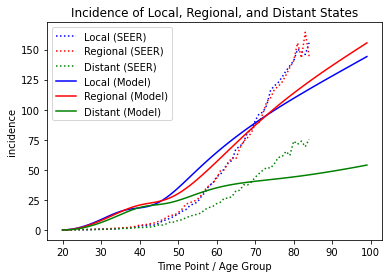

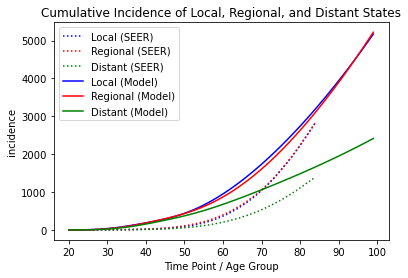

In [53]:
### Plotting
inc_adj, _,_,_ = curr_log
x_values = np.linspace(20,99,80)

plt.plot(seer_inc['Age'], seer_inc['Local Rate'], label = 'Local (SEER)', color='b',linestyle="dotted")
plt.plot(seer_inc['Age'], seer_inc['Regional Rate'], label = 'Regional (SEER)', color='r', linestyle="dotted")
plt.plot(seer_inc['Age'], seer_inc['Distant Rate'],  label='Distant (SEER)', color='g',linestyle="dotted")
plt.plot(x_values, inc_adj[6,:], label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:],  label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:],  label='Distant (Model)', color='g')
plt.legend()
plt.title('Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

plt.plot(seer_inc['Age'], seer_inc['Local Rate'].cumsum(), label = 'Local (SEER)', color='b',linestyle="dotted")
plt.plot(seer_inc['Age'], seer_inc['Regional Rate'].cumsum(), label = 'Regional (SEER)', color='r',linestyle="dotted")
plt.plot(seer_inc['Age'], seer_inc['Distant Rate'].cumsum(), label = 'Distant (SEER)', color='g',linestyle="dotted")
plt.plot(x_values, inc_adj[6,:].cumsum(), label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:].cumsum(), label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:].cumsum(), label='Distant (Model)', color='g')
plt.legend()
plt.title('Cumulative Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

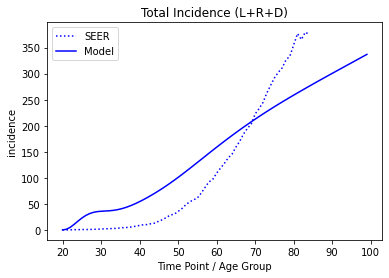

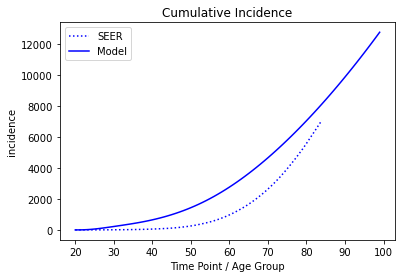

In [37]:
### Plotting
inc_adj, _,_,_ = curr_log
x_values = np.linspace(20,99,80)
seer_inc['Total Rate'] = seer_inc['Local Rate'] + seer_inc['Regional Rate'] + seer_inc['Distant Rate']

plt.plot(seer_inc['Age'], seer_inc['Total Rate'], label = 'SEER', color='b',linestyle="dotted")
plt.plot(x_values, np.sum(inc_adj[6:9,:],axis=0), label='Model', color='b')
plt.legend()
plt.title('Total Incidence (L+R+D)')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

plt.plot(seer_inc['Age'], seer_inc['Total Rate'].cumsum(), label = 'SEER', color='b',linestyle="dotted")
plt.plot(x_values, np.sum(inc_adj[6:9,:],axis=0).cumsum(), label='Model', color='b')
plt.legend()
plt.title('Cumulative Incidence')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

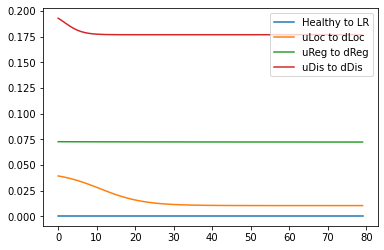

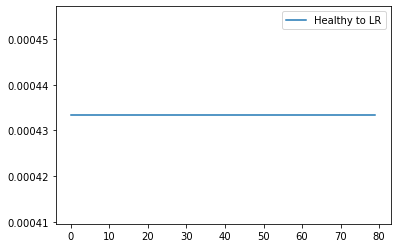

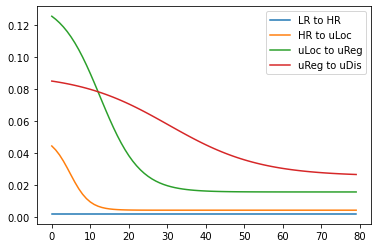

In [38]:
plt.plot(curr_tmat[:,0,1], label = "Healthy to LR")
plt.plot(curr_tmat[:,3,6], label = "uLoc to dLoc")
plt.plot(curr_tmat[:,4,7], label = "uReg to dReg")
plt.plot(curr_tmat[:,5,8], label = "uDis to dDis")
plt.legend()
plt.show()

plt.plot(curr_tmat[:,0,1], label = "Healthy to LR")
plt.legend()
plt.show()

plt.plot(curr_tmat[:,1,2], label = "LR to HR")
plt.plot(curr_tmat[:,2,3], label = "HR to uLoc")
plt.plot(curr_tmat[:,3,4], label = "uLoc to uReg")
plt.plot(curr_tmat[:,4,5], label = "uReg to uDis")
plt.legend()
plt.show()